In [1]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
\
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
# from tqdm.notebook import tqdm
from IPython.display import display, Math

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import proplot as pplt  #https://proplot.readthedocs.io/en/stable/basics.html

import sklearn
import sklearn.decomposition

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

C:\Users\abel_\anaconda3\lib\site-packages\proplot\__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [116]:
# exp_list = glob.glob(current_dir+"\\experiments\\poisson_clicks\\nrec_limit\\*")
exp_list = glob.glob(current_dir+"\\experiments\\poisson_clicks\\exp_ac*1664381906")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))

last_i = 9
exp_path = exp_list[-last_i]
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\exp_actnormlambda0.0001_40_Nrec10_idx20_1664381906'

In [117]:
# exp_path = current_dir + 'exp_single_sumofrates1000.0_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec1_1656020558exp_single_sumofrates1000.0_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec1_1656020558' #
# exp_path = exp_list[-last_i]
idx = exp_path[-10:]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

idx = int(re.search(r'\d+', exp_path).group())

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)

# file = train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

Nrec = training_kwargs['N_rec']

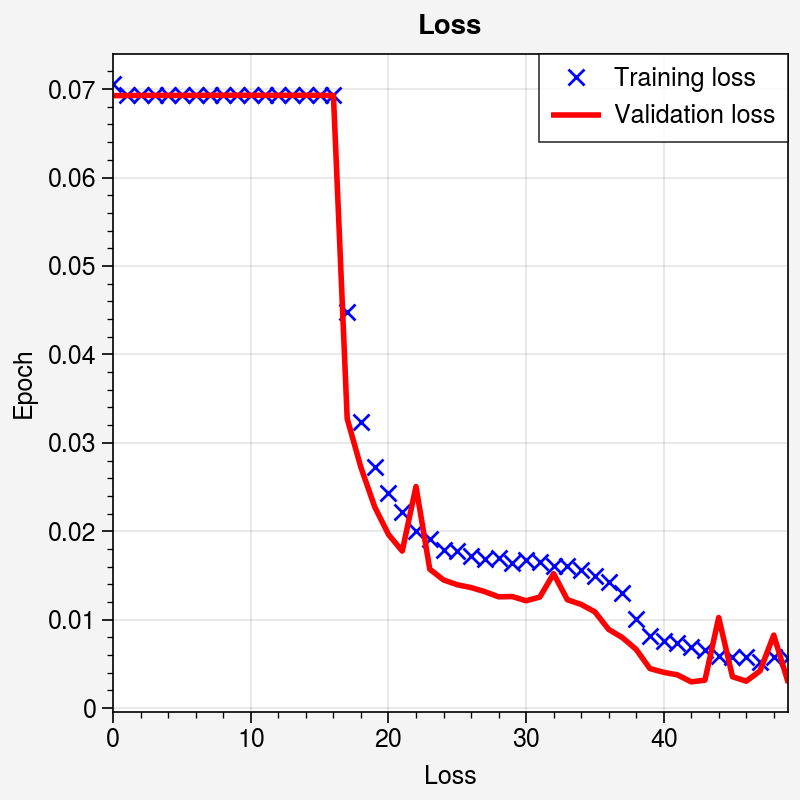

In [118]:
with open(training_kwargs['exp_path'] + '/learning_info.pickle', 'rb') as handle:
    learning_info = pickle.load(handle)
epoch_counter = 0
losses = learning_info['training_loss']
val_losses = learning_info['validation_loss']

fig = pplt.figure(figsize=(4,4), suptitle='Loss')
ax = fig.subplot(ylabel='Epoch', xlabel='Loss')
ax.plot(range(epoch_counter, epoch_counter+len(losses)), losses, 'bx', label="Training loss", lw=2)
ax.plot(range(epoch_counter, epoch_counter+len(losses)), val_losses, 'r', label="Validation loss", lw=2)
# plt.legend(['Training loss', 'Validation loss'])
plt.legend(ncols=1, loc='upper right')

# plt.savefig(training_kwargs['figures_path'] + '/losses_opt'+training_kwargs['optimizer']+'lr'+str(training_kwargs['learning_rate'])+'.pdf')

In [119]:
# Dynamics

In [120]:
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set

In [121]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

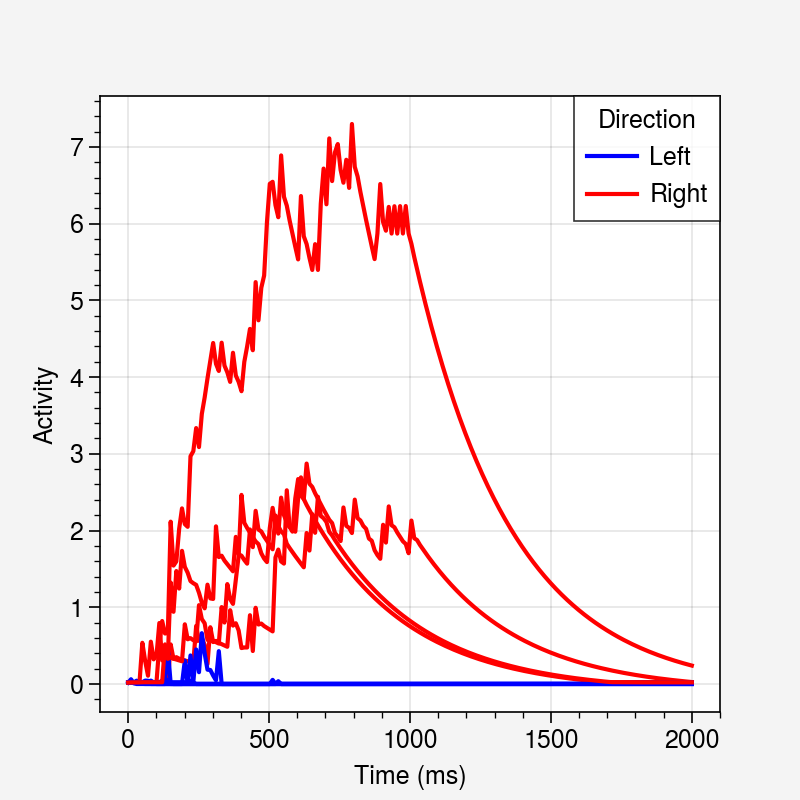

In [122]:
# hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
# hidden_states = hidden_states.detach().numpy()
directions = np.array([np.where(trial_params[i]['ratio']>1.,1,0) for i in range(trial_params.shape[0])])
colors_list = ['b', 'r']
for trial_i in range(10):
    direction = directions[trial_i]
    plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0], colors_list[direction])
# plt.ylim([0,1]);
plt.legend(['Left', 'Right'], title='Direction')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.xlabel("Time (ms)")
plt.ylabel("Activity")
# plt.ylim([0,1])
plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_10.pdf', bbox_inches="tight")

In [123]:
#PCA for various ratios data
test_kwargs_left = training_kwargs
min_ratio = 1.1
max_ratio = 2
test_kwargs_left['ratios'] = training_kwargs['ratios']
# np.array([np.linspace(min_ratio, max_ratio, 3), np.linspace(-max_ratio, -min_ratio, 3)]).flatten()
data_size = 10000
pc = PoissonClicks(N_batch=data_size, training_kwargs=test_kwargs_left)
x, y, output_mask, trial_params = pc.get_trial_batch() 
data_set = [x, y, output_mask, trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'wb') as handle:
#     pickle.dump(data_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
#     data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)

In [124]:
#initialize hidden states
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

yhat, _ = rnn_model(inputs)
yhat = yhat.detach().numpy()

Ratio:  12.333333333333334


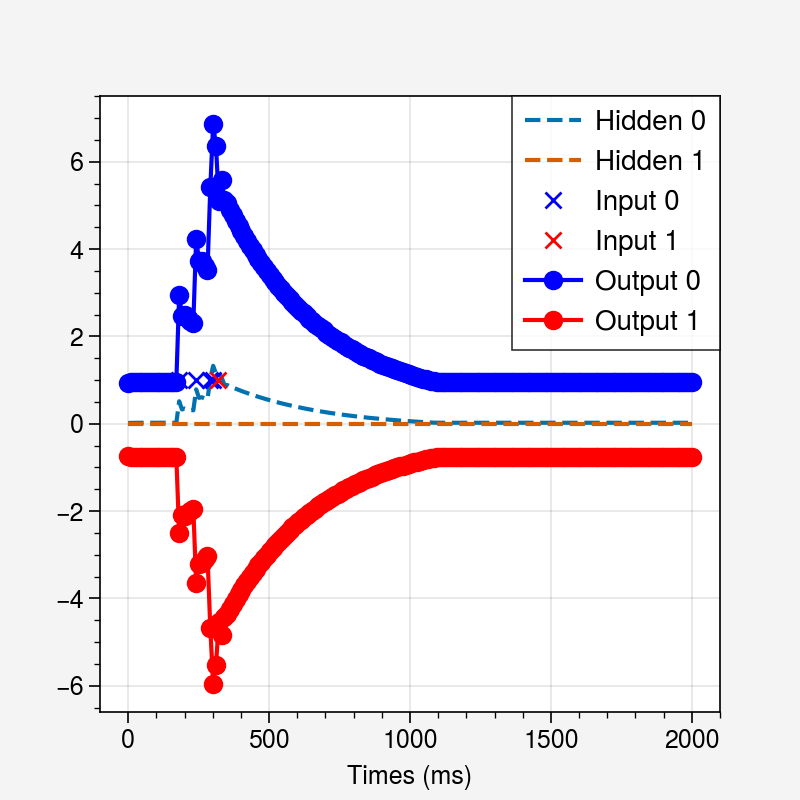

In [125]:
directions = np.array([trial_params[i]['ratio']<1. for i in range(trial_params.shape[0])])
ratios = np.array([trial_params[i]['ratio'] for i in range(trial_params.shape[0])])

np.where(directions==0)[0]

trial_i = 9
print("Ratio: ", trial_params[trial_i]['ratio']) 
times = np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0])
if training_kwargs['N_rec']==1:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden')
else:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden 0')
    plt.plot(times, hidden_states[trial_i, :, 1], '--', label='Hidden 1')
plt.plot(np.where(x[trial_i,:,0]>0)[0]*10, x[trial_i, x[trial_i,:,0]>0, 0], 'xb', label='Input 0')
plt.plot(np.where(x[trial_i,:,1]>0)[0]*10, x[trial_i, x[trial_i,:,1]>0, 1], 'xr', label='Input 1')

plt.plot(times, yhat[trial_i,:,0], '-ob', label='Output 0')
plt.plot(times, yhat[trial_i,:,1], '-or', label='Output 1')

# plt.plot(times, y[trial_i,:,0], 'ob')
# plt.plot(times, y[trial_i,:,1], 'or')
plt.xlabel("Times (ms)")
# plt.ylim([-7,7])
plt.legend(loc='upper right', prop={'size': 10}); # Put a legend to the right of the current axis
plt.savefig(training_kwargs['figures_path'] + '\\hiddenact_example_ratio%s.pdf'%(trial_params[trial_i]['ratio']))